https://www.kaggle.com/code/gauravmalik26/food-delivery-fe-stacking-and-ensemble#Feature-Selection

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer,MissingIndicator, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV,RepeatedStratifiedKFold,cross_val_score,cross_val_predict
from sklearn.preprocessing import PowerTransformer,OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer,make_column_selector,ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.impute import  KNNImputer
from sklearn.svm import SVC
from lightgbm import LGBMRegressor, LGBMClassifier
import xgboost as xgb

import warnings; warnings.filterwarnings("ignore")

#from kuma_utils.preprocessing.imputer import LGBMImputer 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import PolynomialFeatures
from geopy.distance import geodesic

import gc

from category_encoders import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import KBinsDiscretizer,LabelEncoder
from feature_engine.encoding import OrdinalEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures
from feature_engine.selection import (RecursiveFeatureElimination, RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection,DropCorrelatedFeatures
)
from feature_engine.creation import MathFeatures,RelativeFeatures

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder
from sklearn import metrics
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.cluster import KMeans
from category_encoders import MEstimateEncoder,OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import KBinsDiscretizer


from sklearn.ensemble import StackingRegressor

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor ,AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet, LassoLars, PassiveAggressiveRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, metrics, Pool, cv
pd.set_option('display.max_columns', None)

In [2]:
# DATA LOADING
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# DATA CLEANING

#test=test.replace(" ","")
test=test.replace('NaN', float(np.nan), regex=True)

#train=train.replace(" ","")
train=train.replace('NaN', float(np.nan), regex=True)

train['Weatherconditions']=train['Weatherconditions'].str.split(" ", expand=True)[1]
test['Weatherconditions']=test['Weatherconditions'].str.split(" ", expand=True)[1]

train['Time_taken(min)']=train['Time_taken(min)'].str.split(" ", expand=True)[1]

num_cols = ['Delivery_person_Age','Delivery_person_Ratings','Restaurant_latitude','Restaurant_longitude',
            'Delivery_location_latitude','Delivery_location_longitude','Vehicle_condition',
            'multiple_deliveries','Time_taken(min)']
for col in num_cols:
    train[col]=train[col].astype('float64')
    
for col in num_cols[:-1]:
    test[col]=test[col].astype('float64')
    
train['Order_Date']=pd.to_datetime(train['Order_Date'],format="%d-%m-%Y")
test['Order_Date']=pd.to_datetime(test['Order_Date'],format="%d-%m-%Y")

train['Time_Orderd']=pd.to_timedelta(train['Time_Orderd'])
train['Time_Order_picked']=pd.to_timedelta(train['Time_Order_picked'])

train['Time_Order_picked_formatted']=np.where(train['Time_Order_picked'] < train['Time_Orderd'], train['Order_Date'] + pd.DateOffset(1)+train['Time_Order_picked'], train['Order_Date']+train['Time_Order_picked'])
train['Time_Ordered_formatted'] = train['Order_Date']+ train['Time_Orderd']
train['order_prepare_time_diff_mins']=((train['Time_Order_picked_formatted']- train['Time_Ordered_formatted']).dt.total_seconds())/60

test['Time_Orderd']=pd.to_timedelta(test['Time_Orderd'])
test['Time_Order_picked']=pd.to_timedelta(test['Time_Order_picked'])

test['Time_Order_picked_formatted']=np.where(test['Time_Order_picked'] < test['Time_Orderd'], test['Order_Date'] + pd.DateOffset(1)+test['Time_Order_picked'], test['Order_Date']+test['Time_Order_picked'])
test['Time_Ordered_formatted'] = test['Order_Date']+ test['Time_Orderd']
test['order_prepare_time_diff_mins']=((test['Time_Order_picked_formatted']- test['Time_Ordered_formatted']).dt.total_seconds())/60

cols=['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']
for col in cols:
    train[col]= abs(train[col])
for col in cols:
    test[col]= abs(test[col])

In [4]:
# Creating new features on the basis of latitude and longitude
train['distance_diff_KM']=np.zeros(len(train))
restaurant_cordinates_train=train[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
delivery_location_cordinates_train=train[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()

for i in range(len(train)):
    train['distance_diff_KM'].loc[i]=geodesic(restaurant_cordinates_train[i],delivery_location_cordinates_train[i])

test['distance_diff_KM']=np.zeros(len(test))
restaurant_cordinates_test=test[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
delivery_location_cordinates_test=test[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()

for i in range(len(test)):
    test['distance_diff_KM'].loc[i]=geodesic(restaurant_cordinates_test[i],delivery_location_cordinates_test[i])

y=train["Time_taken(min)"]
train = train.drop(columns=["Time_taken(min)",'ID'],axis=1)
Id= test['ID'].str.strip()
test = test.drop(columns=["ID"],axis=1)

data=pd.concat([train,test]).reset_index(drop=True)
data.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_Order_picked_formatted,Time_Ordered_formatted,order_prepare_time_diff_mins,distance_diff_KM
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,0 days 11:30:00,0 days 11:45:00,Sunny,High,2.0,Snack,motorcycle,0.0,No,Urban,2022-03-19 11:45:00,2022-03-19 11:30:00,15.0,3.0207366434610656 km
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,0 days 19:45:00,0 days 19:50:00,Stormy,Jam,2.0,Snack,scooter,1.0,No,Metropolitian,2022-03-25 19:50:00,2022-03-25 19:45:00,5.0,20.143736910348597 km
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,0 days 08:30:00,0 days 08:45:00,Sandstorms,Low,0.0,Drinks,motorcycle,1.0,No,Urban,2022-03-19 08:45:00,2022-03-19 08:30:00,15.0,1.549692932239406 km
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,0 days 18:00:00,0 days 18:10:00,Sunny,Medium,0.0,Buffet,motorcycle,1.0,No,Metropolitian,2022-04-05 18:10:00,2022-04-05 18:00:00,10.0,7.774496620087613 km
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,0 days 13:30:00,0 days 13:45:00,Cloudy,High,1.0,Snack,scooter,1.0,No,Metropolitian,2022-03-26 13:45:00,2022-03-26 13:30:00,15.0,6.197897916874956 km


In [5]:
na_cols=[]
for col in data.columns:
    if data[col].isna().sum()>0:
        na_cols.append(col)

data["n_missing"]= data[na_cols].isna().sum(axis=1)
data_missing_tag_df = data[na_cols].isna().astype(np.int8)
data_missing_tag_df.columns = [f"{c}_missing" for c in data_missing_tag_df.columns]

data=pd.concat([data, data_missing_tag_df], axis=1)

In [6]:
# Creating time based features
data["day"] = data.Order_Date.dt.day
data["week"] = data.Order_Date.dt.isocalendar().week
data["month"] = data.Order_Date.dt.month
data["quarter"] = data.Order_Date.dt.quarter
data["year"] = data.Order_Date.dt.year
data["hour"] = data.Time_Orderd.dt.components['hours']
data["dayofyear"] = data.Order_Date.dt.dayofyear
data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
data["is_leap_year"] = data.Order_Date.dt.is_leap_year.astype(int)
data["days_in_month"] = data.Order_Date.dt.days_in_month
data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)
data['distance_diff_KM']=data['distance_diff_KM'].astype("str").str.extract('(\d+)')
data['distance_diff_KM']=data['distance_diff_KM'].astype("int64")

data=data.drop(columns=['Order_Date','Time_Orderd','Time_Order_picked'],axis=1)
data=data.drop(columns=['Time_Order_picked_formatted','Time_Ordered_formatted'])

data['week']=data['week'].astype("int64")

for col in data.columns:
    if data[col].dtype == 'uint8':
        data[col]=data[col].astype("int64")
        
data['city_code']=data['Delivery_person_ID'].str.split("RES", expand=True)[0]
data=data.drop(columns=["Delivery_person_ID" ],  axis=1)

In [7]:
# Removing constant and duplicate features
pipe = Pipeline([
   ('constant', DropConstantFeatures(tol=0.998,missing_values='ignore')),
   ('duplicated', DropDuplicateFeatures(missing_values='ignore')),                         
])
data=pipe.fit_transform(data)

In [8]:
# More Feature Engineering
num_ft = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
mf=MathFeatures(['Delivery_person_Age','Delivery_person_Ratings'],missing_values='ignore',func= ["std",'mean'])
data=mf.fit_transform(data)

In [9]:
feat1=data.groupby("Delivery_person_Age")["Delivery_person_Ratings"].transform("mean")
data['feat2']=data['Delivery_person_Ratings'] - feat1

feat3=data.groupby("Delivery_person_Age")["Delivery_person_Ratings"].transform("std")
data['feat4']=data['Delivery_person_Ratings'] - feat3

data['feat9']=data.groupby(["Weatherconditions",'Road_traffic_density'])["Delivery_person_Age"].transform("mean")
#data['feat10']=data['Delivery_person_Age'] - data['feat9']

feat11=data.groupby(["Weatherconditions",'Road_traffic_density'])["Delivery_person_Age"].transform("std")
data['feat12']=data['Delivery_person_Age'] - feat11

data['feat13']=data.groupby(["Weatherconditions",'Road_traffic_density','City','city_code'])["distance_diff_KM"].transform("std")
data['feat14']=data['Delivery_person_Age'] - data['feat13']

In [10]:
# Target encoding
encoder = MEstimateEncoder(m=1)

train= data[:len(train)]
test=data[len(train):]

train =  encoder.fit_transform(train,y)
test= encoder.transform(test)

In [11]:
xgb_model=xgb.XGBRegressor(n_estimators=25,max_depth=7)
lgb = LGBMRegressor(num_leaves=85,max_depth=8,learning_rate=0.1)
cat= CatBoostRegressor(n_estimators=700,max_depth=8,learning_rate=0.05)

In [12]:
selected_feat_=['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'multiple_deliveries',
 'Festival',
 'City',
 'distance_diff_KM',
 'n_missing',
 'Weatherconditions_missing',
 'multiple_deliveries_missing',
 'Festival_missing',
 'City_missing',
 'is_month_end',
 'is_quarter_start',
 'is_weekend',
 'feat2',
 'feat9',
 'feat12']

In [13]:
imp_feat=selected_feat_[:12]

In [14]:
# Stacking
#best_1

estimators = [
     ('xgb_model', xgb_model),
     ('lgb', lgb),('cat',cat)]
# best
reg = StackingRegressor(
estimators=estimators,
 final_estimator=xgb_model)

xgb_model.fit(train[imp_feat],y)
reg.fit(train,y)
lgb.fit(train[imp_feat],y)
cat.fit(train[imp_feat],y)

reg_pred=reg.predict(test)
lgb_pred=lgb.predict(test[imp_feat])
cat_pred=cat.predict(test[imp_feat])
xgb_pred=xgb_model.predict(test[imp_feat])

ensemble=reg_pred*0.2 + lgb_pred*0.45 + cat_pred*0.35  # Using these ratios after lots of experimenting

0:	learn: 9.0294834	total: 213ms	remaining: 2m 28s
1:	learn: 8.6952508	total: 244ms	remaining: 1m 25s
2:	learn: 8.3602180	total: 266ms	remaining: 1m 1s
3:	learn: 8.0666730	total: 290ms	remaining: 50.5s
4:	learn: 7.7683223	total: 312ms	remaining: 43.4s
5:	learn: 7.5090658	total: 336ms	remaining: 38.8s
6:	learn: 7.2445646	total: 360ms	remaining: 35.7s
7:	learn: 7.0204333	total: 384ms	remaining: 33.2s
8:	learn: 6.8077370	total: 409ms	remaining: 31.4s
9:	learn: 6.6081442	total: 442ms	remaining: 30.5s
10:	learn: 6.4250621	total: 466ms	remaining: 29.2s
11:	learn: 6.2309588	total: 490ms	remaining: 28.1s
12:	learn: 6.0673957	total: 513ms	remaining: 27.1s
13:	learn: 5.9149389	total: 535ms	remaining: 26.2s
14:	learn: 5.7728985	total: 558ms	remaining: 25.5s
15:	learn: 5.6515749	total: 580ms	remaining: 24.8s
16:	learn: 5.5168847	total: 605ms	remaining: 24.3s
17:	learn: 5.4151680	total: 633ms	remaining: 24s
18:	learn: 5.3014673	total: 658ms	remaining: 23.6s
19:	learn: 5.2029740	total: 680ms	remaini

# SHAP

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


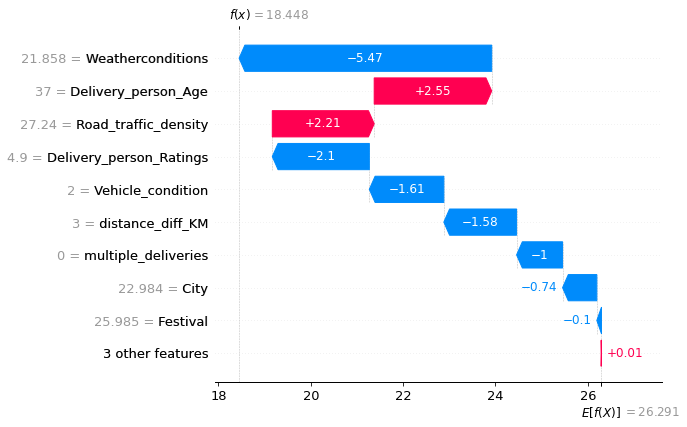

In [15]:
import xgboost
import shap

# train an XGBoost model
# X, y = shap.datasets.boston()
model = xgb_model.fit(train[imp_feat],y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(train[imp_feat])

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [16]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

In [17]:
# visualize all the training set predictions
# shap.initjs()
# shap.plots.force(shap_values)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


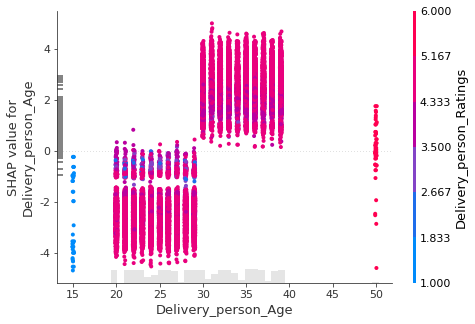

In [18]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Delivery_person_Age"], color=shap_values)

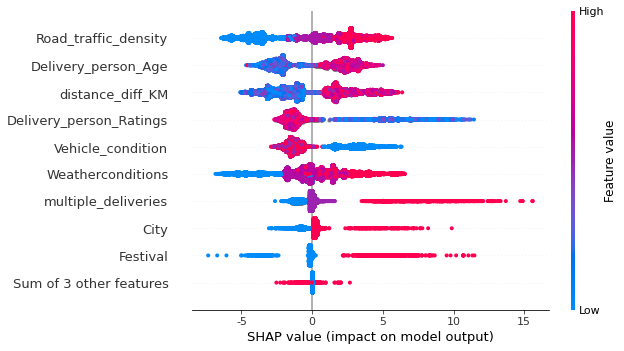

In [19]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

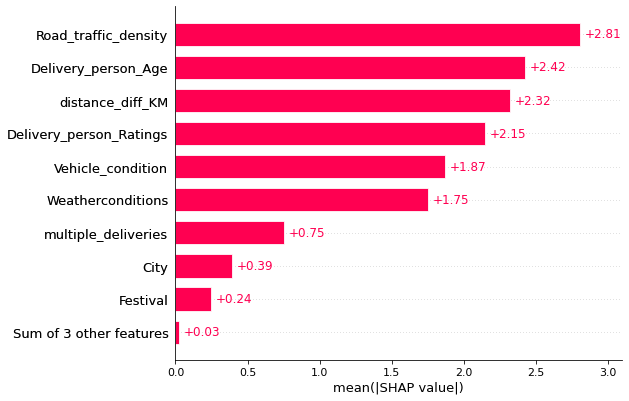

In [20]:
shap.plots.bar(shap_values)